In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

In [2]:
class Simple_Dist:
    
    # param = [(points,values)]
    # constructed left-to-right on [0,1]
    def __init__(self, init, end= 1):
        self.param = init
        self.end = end
        
    def display(self):
        points = []
        a_param = self.param + [(1,self.param[-1][1])]
        for i, v in enumerate(a_param[:-1]):
            points.append(v)
            points.append((a_param[i+1][0],v[1]))
        x,y = zip(*points)
        plt.plot(x,y)
        plt.title("Median Density")
        plt.ylabel("Density")
        plt.xlabel("Value")
    
    def cdf(self,threshold):
        basis = []
        val = []
        a_param = self.param + [(1,self.param[-1][1])]
        for i, v in enumerate(a_param):
            if v[0] < threshold:
                basis.append(v[0])
                val.append(v[1])
            else:
                basis.append(threshold)
                cdf = 0
                for i, d in enumerate(val):
                    cdf += d*(basis[i+1]-basis[i])
                return cdf
            
    def invcdf(self, prob):
        a_param = self.param + [(self.end,self.param[-1][1])]
        cdf = 0
        for i, v in enumerate(a_param[:-1]):
            if cdf+v[1]*(a_param[i+1][0]-a_param[i][0])>prob:
                exceed = cdf+v[1]*(a_param[i+1][0]-a_param[i][0])-prob
                return a_param[i+1][0]-exceed/v[1]
            else:
                cdf += v[1]*(a_param[i+1][0]-a_param[i][0])
    
    def median(self):
        return self.invcdf(0.5)
  
    # Vote indicates for direction
    def update_dist(self, threshold, vote, alpha = 0.1, beta = 0.0):
        
        if beta == 0.0:
            beta = 1+alpha
        
        # Insert new data
        index = next(i for i,v in enumerate(self.param+[(1,self.param[-1][1])]) if threshold < v[0])
        if index < len(self.param) and self.param[index][0] != threshold:
            self.param.insert(index,(threshold,self.param[index-1][1]))
        elif index >= len(self.param):
            self.param.insert(index,(threshold,self.param[index-1][1]))
            
        # Modify distribution
        if vote == -1:
            r_mass = 1 - self.cdf(threshold)
            for i, v in enumerate(self.param):
                if v[0] < threshold:
                    self.param[i] = (v[0],v[1] * (1 - alpha) / beta)
                else:
                    self.param[i] = (v[0],v[1] * alpha / beta)
            norm = self.cdf(1)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)
        else:
            l_mass = self.cdf(threshold)
            for i, v in enumerate(self.param):
                if v[0] >= threshold:
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                else:
                    self.param[i] = (v[0],v[1] * alpha)
            norm = self.cdf(1)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)

In [3]:
# true metric
m_star = (-0.94,-0.34) #200 degree
m_star = (0.98,0.17) #11.47 degree

m_star = m_star/np.linalg.norm(m_star)  # normalize
# obtain true theta
t_true = np.arccos(m_star[0])
if t_true > np.pi/2:  # make sure theta either in [0, pi/2] or [pi, 3/2*pi]
    t_true = np.pi*2-t_true

print(t_true)

def eta(x):
    return 1/(1+np.exp(5*x))

# confusion matrix, analytical solution
def C11(t):  # P(Y=1, h=1)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0.
  h = h = lambda x: hb(x,t)
  if m00 == 0:
    x_prime = 1
  elif m11/m00 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return (x_prime-0.2*np.log(1+np.exp(5*x_prime))+1+0.2*np.log(1+np.exp(-5))) # x-0.2ln(1+e^5x)
  else:
    return (1-0.2*np.log(1+np.exp(5))-x_prime+0.2*np.log(1+np.exp(5*x_prime)))

def C10(t):  # P(Y=0, h=1)
  return 1-C11(t)

def C01(t):  # P(Y=1, h=0)
  return 1-C00(t)

def C00(t):  # P(Y=0, h=0)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0
  h = lambda x: hb(x,t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return (0.2*np.log(1+np.exp(5))-0.2*np.log(1+np.exp(5*x_prime)))  # ln(1+e^5x)
  else:
    return (0.2*np.log(1+np.exp(5*x_prime))-0.2*np.log(1+np.exp(-5)))

# metric evaluation
def phi(t, t_true):
  m11, m00 = np.cos(t_true), np.sin(t_true)
  return m11*C11(t)+m00*C00(t)

def gen_data(size,eta):
    data = []
    labels = [0,1]
    for i in range(size):
        x = 2*np.random.sample(1)[0]-1
        data.append((x,np.random.choice(labels,size = 1, p = [1-eta(x),eta(x)])[0]))
    return data

def hb(x,theta):
    m00, m11 = np.cos(theta), np.sin(theta)
    if m11+m00 >= 0:
      return int(eta(x)>=m00/(m11+m00))
    else:
      return int(eta(x)<=m00/(m11+m00))
    
def classify(theta,x):
  return hb(x,theta)

def f_phi(theta,t,classify,data):
    TP = [0]
    TN = [0]
    for (x,y) in data:
        if y == 0:
            TP.append(1-classify(t,x))
        if y == 1:
            TN.append(classify(t,x))
    return np.mean(TP)*np.cos(theta)+np.mean(TN)*np.sin(theta)

0.17176015132820346


0.2910093417162608


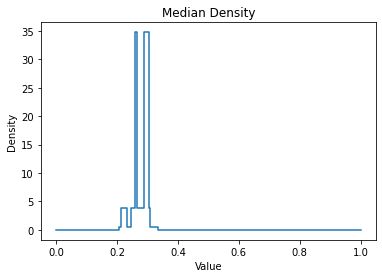

In [11]:
dist = Simple_Dist([(0,1)])
# dist.update_dist(0.5,1, alpha = alpha)
opt = 0.3
alpha = 0.1
num = 100
query = np.random.rand(num,2)
func = lambda x : x*(1-x)
run= []
for i in range(num):
    if query[i][0] < opt:
        if query[i][1] > alpha:
            dist.update_dist(query[i][0],1, alpha = alpha)
        else:
            dist.update_dist(query[i][0],-1, alpha = alpha)
    else:
        if query[i][1] > alpha:
            dist.update_dist(query[i][0],-1, alpha = alpha)
        else:
            dist.update_dist(query[i][0],1, alpha = alpha)
    run.append(dist.median())
dist.display()
print(dist.median())

## Markov Chain Algorithm

In [4]:
dist = Simple_Dist([(0,1)])
states = []
medians = []
# dist.update_dist(0.5,1, alpha = alpha)
opt = 0.3
alpha = 0.1
num = 100
query = np.random.rand(num,2)
func = lambda x : x*(1-x)
run= []
s = 0
k=0
for i in range(num):
    if (num)%int(1/(1-2*alpha))==0: # run one step PBA
        if query[i][0] < opt:
            if query[i][1] > alpha:
                dist.update_dist(query[i][0],1, alpha = alpha)
            else:
                dist.update_dist(query[i][0],-1, alpha = alpha)
        else:
            if query[i][1] > alpha:
                dist.update_dist(query[i][0],-1, alpha = alpha)
            else:
                dist.update_dist(query[i][0],1, alpha = alpha)
        run.append(dist.median())
        run.sort()
    local_len = len(run)
    if i == 0:
        s = run[0]
        continue
    sL = run[0] if k==0 else run[k-1]
    sR = run[local_len-1] if k==local_len-1 else run[k+1]
    if s<opt:
        s=sR
        k = local_len-1 if k==local_len-1 else k+1
    else:
        s=sL
        k = 0 if k==0 else k-1
#     print(s,sL,sR,k)
    states.append(abs(opt-s))
    medians.append(abs(opt-dist.median()))
# print(s)
# print(dist.median())

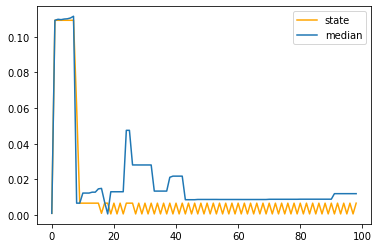

In [21]:
plt.plot(states,c='orange',label='state')
plt.plot(medians,label='median')
plt.legend()

## PBA experiment demo

In [5]:
def phi_query(t_1, t_2, alpha, t_phi):
  if t_phi(t_1) < t_phi(t_2):
    if np.random.rand() > alpha:
      return 1  # prefer t2
    else:
      return 0
  else:
    if np.random.rand() > alpha:
      return 0  # prefer t1
    else:
      return 1
    
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def gaurush(iteration, alpha, t_phi):
    query = lambda t_1, t_2, alpha : phi_query(t_1,t_2,alpha,t_phi)
    t_a = 0
    t_b = np.pi/2
    m_bar = np.zeros(2)
    C_bar = 0
    iter = 0
    run = []
    t_d=0
    for iter in range(iteration):
        # divide the searching range into equally seperated intervals
        t_c = (3*t_a+t_b)/4
        t_d = (t_a+t_b)/2
        t_e = (t_a+3*t_b)/4
        # compute Confusion Matrices
        C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
        C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
        C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
        C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
        C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
        # pairwise comparisons
        ca = query(t_c, t_a, alpha)
        dc = query(t_d, t_c, alpha)
        ed = query(t_e, t_d, alpha)
        be = query(t_b, t_e, alpha)

        # sanity check for out-of-order responses
        if ca and not dc:
            ca = not ca
        if dc and not ed:
            dc = not dc
        if ed and not be:
            ed = not ed

        # determine the next iter search range based on oracle resposne to query
        if ca:
            t_b = t_d
        elif not ca and dc:
            t_b = t_d
        elif not dc and ed:
            t_a = t_c
            t_b = t_e
        elif not ed and be:
            t_a = t_d
        else:
            t_a = t_d
        
        m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
        C_bar = C_d
        iter += 1
        run = run + [t_d,t_d,t_d,t_d]
        # print("iteration run:"+str(iter))
    return np.array(run) , t_d

In [6]:
def pba(iteration, alpha, opt):
    dist = Simple_Dist([(0,1)])
    # dist.update_dist(0.5,1, alpha = alpha)
    query = np.random.rand(iteration,2)
    func = lambda x : x*(1-x)
    run= []
    for i in range(iteration):
        if query[i][0] < opt:
            if query[i][1] > alpha:
                dist.update_dist(query[i][0],1, alpha = alpha)
            else:
                dist.update_dist(query[i][0],-1, alpha = alpha)
        else:
            if query[i][1] > alpha:
                dist.update_dist(query[i][0],-1, alpha = alpha)
            else:
                dist.update_dist(query[i][0],1, alpha = alpha)
        run.append(dist.median())
    return np.array(run) , dist.median()

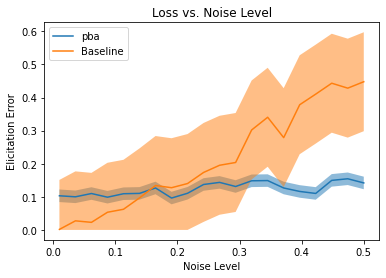

In [40]:
alpha = np.linspace(0.01,0.5,20)
avg_loss_pba = []
avg_loss_g = []
for a in alpha:
    loss_pba = []
    loss_g = []
    for i in range(100):
        t_true = random.uniform(0,np.pi/2)
        _, hat_t = pba(iteration = 100, alpha = a / (1+a), opt=t_true)
        loss_pba.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)]))
        _, hat_t = gaurush(iteration = 25, alpha = a, t_phi = lambda t: phi(t,t_true))
        loss_g.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)]))
    avg_loss_pba.append(np.mean(loss_pba))
    avg_loss_g.append(np.mean(loss_g))

plt.plot(alpha,avg_loss_pba, label = "pba")
avg_loss_pba = np.array(avg_loss_pba)
plt.fill_between(alpha,np.maximum(0,avg_loss_pba - np.std(avg_loss_pba)), avg_loss_pba + np.std(avg_loss_pba), alpha = 0.5)

plt.plot(alpha,avg_loss_g, label = "Baseline")
avg_loss_pba = np.array(avg_loss_g)
plt.fill_between(alpha,np.maximum(0,avg_loss_g - np.std(avg_loss_g)), avg_loss_g + np.std(avg_loss_g), alpha = 0.5)
plt.xlabel("Noise Level")
plt.ylabel("Elicitation Error")
plt.title("Loss vs. Noise Level")
plt.legend(loc = "upper left")
plt.savefig("noise_curve.png")

ValueError: x and y must have same first dimension, but have shapes (24,) and (25,)

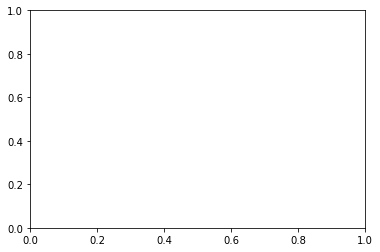

In [61]:
import random
a = 0.25

avg_loss_pba = []
avg_loss_g = []
for num in range(10,251,10):
    loss_pba = []
    loss_g = []
    for i in range(100): 
        t_true = random.uniform(0,np.pi/2)
        hat_t, _ = gaurush(iteration = num, alpha = a, t_phi = lambda t: phi(t,t_true))
        loss_g.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)], axis = 0))
        hat_t, _ = pba(iteration = 4*num, alpha = a / (1+a), opt=t_true)
        loss_pba.append(np.linalg.norm([np.cos(hat_t)-np.cos(t_true), np.sin(hat_t) - np.sin(t_true)], axis = 0))
    avg_loss_pba.append(np.mean(loss_pba))
    avg_loss_g.append(np.mean(loss_g))

alpha = np.array(range(10,251,10))*4
plt.plot(alpha,avg_loss_pba, label = "pba")
avg_loss_pba = np.array(avg_loss_pba)
plt.fill_between(alpha,np.maximum(0,avg_loss_pba - np.std(avg_loss_pba)), avg_loss_pba + np.std(avg_loss_pba), alpha = 0.5)

plt.plot(alpha,avg_loss_g, label = "Baseline")
avg_loss_pba = np.array(avg_loss_g)
plt.fill_between(alpha,np.maximum(0,avg_loss_g - np.std(avg_loss_g)), avg_loss_g + np.std(avg_loss_g), alpha = 0.5)

plt.xlabel("Number of Elicitations")
plt.ylabel("Elicitation Error")
plt.title(r'Loss vs. Number of Elicitations ($\alpha$ = 0.25)')
plt.legend(loc = "upper right")
plt.savefig("loss_curve.png")

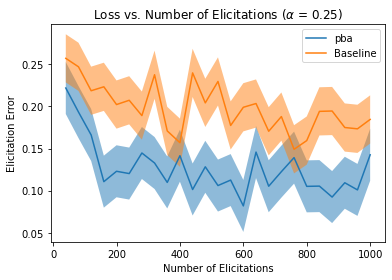

In [62]:
alpha = np.array(range(10,251,10))*4
plt.plot(alpha,avg_loss_pba, label = "pba")
avg_loss_pba = np.array(avg_loss_pba)
plt.fill_between(alpha,np.maximum(0,avg_loss_pba - np.std(avg_loss_pba)), avg_loss_pba + np.std(avg_loss_pba), alpha = 0.5)

plt.plot(alpha,avg_loss_g, label = "Baseline")
avg_loss_pba = np.array(avg_loss_g)
plt.fill_between(alpha,np.maximum(0,avg_loss_g - np.std(avg_loss_g)), avg_loss_g + np.std(avg_loss_g), alpha = 0.5)

plt.xlabel("Number of Elicitations")
plt.ylabel("Elicitation Error")
plt.title(r'Loss vs. Number of Elicitations ($\alpha$ = 0.25)')
plt.legend(loc = "upper right")
plt.savefig("loss_curve.png")